In [0]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential,Model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers, optimizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint,LearningRateScheduler,TensorBoard,EarlyStopping
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from keras import applications 
from PIL import Image,ImageFilter
import os, sys
import glob

from google.colab import drive
from PIL import ImageEnhance



Using TensorFlow backend.


In [0]:
drive.mount('/content/drive')

directory = '/content/drive/My Drive/Colab Notebooks'
training_set = directory+'/MWI-Dataset-1.1_2000/'
#test_set = directory + '/Weather_Dataset/'
test_set = directory +'/MWI-Dataset-1.1.1_400/'
#test_set = directory +'/WeatherBlindTestSet/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def Smoothening(path,type):
  for file_name in glob.iglob(path + '**/*.png', recursive=True):
    print(file_name)
    image = Image.open(file_name)
    smoothenedImage = image.filter(ImageFilter.SMOOTH)    
    
    moreSmoothenedImage = image.filter(ImageFilter.SMOOTH_MORE)   
    if(type=="smoothened"):
      smoothenedImage.save(file_name , 'PNG', quality=100)
    else:
      moreSmoothenedImage.save(file_name , 'PNG', quality=100)
Smoothening(test_set,"moresmoothened")


In [0]:
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.2,\
    rotation_range=6,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)

train_generator = train_datagen.flow_from_directory(
    directory=training_set,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255)

test_generator = test_datagen.flow_from_directory(
    directory=test_set,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 2010 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [0]:
number_samples = train_generator.n
number_classes = train_generator.num_classes
input_shape = train_generator.image_shape

class_names = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %class_names)

print('Loaded %d training samples from %d classes.' %(number_samples,number_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))

Image input (64, 64, 3)
Classes: ['HAZE', 'RAINY', 'SNOWY', 'SUNNY']
Loaded 2010 training samples from 4 classes.
Loaded 400 test samples from 4 classes.


In [0]:
def loadmodel(problem):
    file_name = os.path.join(directory, '%s.h5' %problem)
    try:
        model = load_model(file_name)
        print("\nModel loaded successfully from file %s\n" %file_name)
    except OSError:    
        print("\nModel file %s not found!!!\n" %file_name)
        model = None
    return model

def savemodel(model,typeproblem):
    file_name = os.path.join(directory, '%s.h5' %typeproblem)
    model.save(file_name)
    print("\nModel saved successfully on file %s\n" %file_name)

def LeNet(input_shape, number_classes):
    print('\nLeNet model')
    model = Sequential()

    model.add(Conv2D(filters=6,input_shape=input_shape, kernel_size=(3, 3), activation='relu', padding="same"))
    model.add(AveragePooling2D())

    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())

    model.add(Flatten())

    model.add(Dense(units=120, activation='relu'))

    model.add(Dense(units=84, activation='relu'))

    model.add(Dense(units=number_classes, activation = 'softmax'))
  
    optimizer = 'adam' #alternative 'SGD'
    model.compile(loss=keras.losses.categorical_crossentropy, optimizer=optimizer, metrics=['accuracy'])    
    return model

In [0]:
model = loadmodel('CNN_model')
if model==None:
    model = LeNet(input_shape,number_classes)

model.summary()












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Model loaded successfully from file /content/drive/My Drive/Colab Notebooks/CNN_model.h5

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 6)         168       
_________________________________________________________________
average_pooling2d_1 (Average (None, 32, 32, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 16)        880       
_________________________________________________________________
average_pooling2d_2 (Average (None, 15, 15, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3600)              0         
______________________________________________________

In [0]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1

history = model.fit_generator(train_generator, epochs=15, verbose=1,steps_per_epoch=steps_per_epoch, validation_data=test_generator,validation_steps=val_steps)

savemodel(model,'CNN_model')

val_steps=test_generator.n//test_generator.batch_size+1
loss, acc = model.evaluate_generator(test_generator,verbose=1,steps=val_steps)

print('Test loss in last epoch: %f' %loss)
print('Test accuracy in last epoch: %f' %acc)

Epoch 1/15


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


33/62 [==============>...............] - ETA: 6:15 - loss: 0.4665 - acc: 0.8040

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


47/62 [=====================>........] - ETA: 3:17 - loss: 0.4750 - acc: 0.8029

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1048576 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


55/62 [=========================>....] - ETA: 1:31 - loss: 0.4803 - acc: 0.8009

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


62/62 [==============================] - 832s 13s/step - loss: 0.4764 - acc: 0.8057 - val_loss: 0.4431 - val_acc: 0.8275
Epoch 2/15
62/62 [==============================] - 36s 575ms/step - loss: 0.4359 - acc: 0.8247 - val_loss: 0.4920 - val_acc: 0.8000
Epoch 3/15
62/62 [==============================] - 36s 575ms/step - loss: 0.4277 - acc: 0.8269 - val_loss: 0.4916 - val_acc: 0.8175
Epoch 4/15
62/62 [==============================] - 36s 582ms/step - loss: 0.4117 - acc: 0.8409 - val_loss: 0.4643 - val_acc: 0.8150
Epoch 5/15
62/62 [==============================] - 36s 586ms/step - loss: 0.4185 - acc: 0.8356 - val_loss: 0.4809 - val_acc: 0.7925
Epoch 6/15
62/62 [==============================] - 36s 574ms/step - loss: 0.4075 - acc: 0.8432 - val_loss: 0.5198 - val_acc: 0.7975
Epoch 7/15
62/62 [==============================] - 36s 576ms/step - loss: 0.4387 - acc: 0.8270 - val_loss: 0.5290 - val_acc: 0.7925
Epoch 8/15
62/62 [==============================] - 36s 584ms/step - loss: 0.3887

In [0]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1
preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

print(classification_report(Ytest, Ypred, labels=None, target_names=class_names, digits=4))


val_steps=test_generator.n//test_generator.batch_size+1

preds = model.predict_generator(test_generator,verbose=1,steps=val_steps)

Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(class_names[k[0]],class_names[k[1]],k[2],k[2]*100.0/test_generator.n))

12/13 [==========================>...] - ETA: 0s

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


13/13 [==============================] - 5s 390ms/step
              precision    recall  f1-score   support

        HAZE     0.9375    0.9000    0.9184       100
       RAINY     0.8172    0.7600    0.7876       100
       SNOWY     0.7593    0.8200    0.7885       100
       SUNNY     0.9612    0.9900    0.9754       100

    accuracy                         0.8675       400
   macro avg     0.8688    0.8675    0.8674       400
weighted avg     0.8688    0.8675    0.8674       400

13/13 [==============================] - 5s 386ms/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
RAINY            ->  SNOWY             	19 	4.75 % 
SNOWY            ->  RAINY             	14 	3.50 % 
HAZE             ->  SNOWY             	6 	1.50 % 
SNOWY            ->  HAZE              	4 	1.00 % 
HAZE             ->  RAINY             	3 	0.75 % 
RAINY            ->  SUNNY             	3 	0.75 % 
RAINY            ->  HAZE

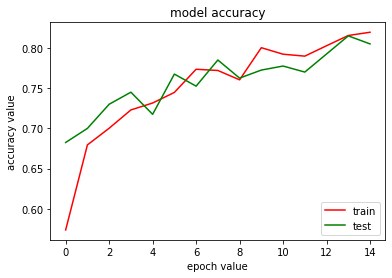

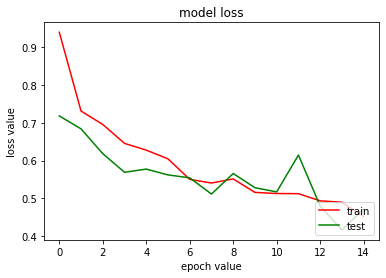

In [0]:
# summarize history for accuracy
plt.plot(history.history['acc'],color='red')
plt.plot(history.history['val_acc'],'#008000')
plt.title('model accuracy')
plt.ylabel('accuracy value')
plt.xlabel('epoch value')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['val_loss'],'#008000')
plt.title('model loss')
plt.ylabel('loss value')
plt.xlabel('epoch value')
plt.legend(['train', 'test'], loc='lower right')
plt.show()  

In [0]:
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=test_generator.n//test_generator.batch_size+1
#model_final = loadmodel('CNN_model_second')
model=keras.applications.VGG16(weights="imagenet",include_top=False,input_shape=input_shape)
model.summary()
#freeze the top layers and add some custom dense layers
for layer in model.layers[:17]:
  layer.trainable=False
  #adding custom layers
x=model.output
x=Flatten()(x)
x=Dense(256,activation="relu")(x)
x=Dropout(0.3)(x)
x=Dense(4096,activation="relu")(x)
#since my problem is multiclass classification with number_class classes add number_class units dense layer and compile the model
predictions=Dense(number_classes,activation="softmax")(x)
model_final=Model(input=model.get_layer(index=0).input,output=predictions)#creating the final 
model_final.summary()
opt='adam'
#model_final.compile(loss=, optmizer=optimizer=)#compile the model

model_final.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

#now we can train the final model
history=model_final.fit_generator(train_generator, epochs=15, verbose=1,steps_per_epoch=steps_per_epoch, validation_data=test_generator,validation_steps=val_steps) 



58892288/58889256 [==============================] - 5s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_____________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Epoch 1/15
 7/62 [==>...........................] - ETA: 58s - loss: 1.3350 - acc: 0.3348

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


11/62 [====>.........................] - ETA: 47s - loss: 1.2492 - acc: 0.4091

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag))


18/62 [=======>......................] - ETA: 34s - loss: 1.0727 - acc: 0.5191

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 4. Skipping tag 41486
  " Skipping tag %s" % (size, len(data), tag))


19/62 [========>.....................] - ETA: 33s - loss: 1.0501 - acc: 0.5296

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 4718592 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 131072 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1048576 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


62/62 [==============================] - 37s 595ms/step - loss: 0.7727 - acc: 0.6740 - val_loss: 0.5725 - val_acc: 0.8150
Epoch 2/15
62/62 [==============================] - 36s 574ms/step - loss: 0.5317 - acc: 0.7998 - val_loss: 0.4789 - val_acc: 0.8250
Epoch 3/15
62/62 [==============================] - 35s 570ms/step - loss: 0.4766 - acc: 0.8161 - val_loss: 0.4091 - val_acc: 0.8225
Epoch 4/15
62/62 [==============================] - 34s 555ms/step - loss: 0.3976 - acc: 0.8519 - val_loss: 0.4015 - val_acc: 0.8475
Epoch 5/15
62/62 [==============================] - 36s 584ms/step - loss: 0.3836 - acc: 0.8553 - val_loss: 0.3357 - val_acc: 0.8600
Epoch 6/15
62/62 [==============================] - 35s 564ms/step - loss: 0.3846 - acc: 0.8580 - val_loss: 0.3533 - val_acc: 0.8650
Epoch 7/15
62/62 [==============================] - 35s 570ms/step - loss: 0.3734 - acc: 0.8638 - val_loss: 0.2667 - val_acc: 0.9050
Epoch 8/15
62/62 [==============================] - 35s 561ms/step - loss: 0.354

In [0]:
#savemodel(model,'CNN_model_second')

print(classification_report(Ytest, Ypred, labels=None, target_names=class_names, digits=4))


val_steps=test_generator.n//test_generator.batch_size+1

preds = model_final.predict_generator(test_generator,verbose=1,steps=val_steps)


Ypred = np.argmax(preds, axis=1)
Ytest = test_generator.classes  # shuffle=False in test_generator

cm = confusion_matrix(Ytest, Ypred)

conf = [] # data structure for confusions: list of (i,j,cm[i][j])
for i in range(0,cm.shape[0]):
  for j in range(0,cm.shape[1]):
    if (i!=j and cm[i][j]>0):
      conf.append([i,j,cm[i][j]])

col=2
conf = np.array(conf)
conf = conf[np.argsort(-conf[:,col])]  # decreasing order by 3-rd column (i.e., cm[i][j])

print('%-16s     %-16s  \t%s \t%s ' %('True','Predicted','errors','err %'))
print('------------------------------------------------------------------')
for k in conf:
  print('%-16s ->  %-16s  \t%d \t%.2f %% ' %(class_names[k[0]],class_names[k[1]],k[2],k[2]*100.0/test_generator.n))
print(Ypred)




              precision    recall  f1-score   support

        HAZE     0.9314    0.9500    0.9406       100
       RAINY     0.8991    0.9800    0.9378       100
       SNOWY     0.9663    0.8600    0.9101       100
       SUNNY     0.9900    0.9900    0.9900       100

    accuracy                         0.9450       400
   macro avg     0.9467    0.9450    0.9446       400
weighted avg     0.9467    0.9450    0.9446       400

11/13 [========================>.....] - ETA: 0s

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:742: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


13/13 [==============================] - 5s 384ms/step
True                 Predicted         	errors 	err % 
------------------------------------------------------------------
SNOWY            ->  HAZE              	7 	1.75 % 
SNOWY            ->  RAINY             	7 	1.75 % 
HAZE             ->  RAINY             	4 	1.00 % 
RAINY            ->  SNOWY             	2 	0.50 % 
HAZE             ->  SUNNY             	1 	0.25 % 
SUNNY            ->  SNOWY             	1 	0.25 % 
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 1 2 2 2 2 0 2 2 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 1 2 2 0 1 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2 2 2 2 

In [0]:

plt.plot(history.history['acc'],color='red')
plt.plot(history.history['val_acc'],'#008000')
plt.title('model accuracy')
plt.ylabel('accuracy value')
plt.xlabel('epoch value')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['val_loss'],'#008000')
plt.title('model loss')
plt.ylabel('loss value')
plt.xlabel('epoch value')
plt.legend(['train', 'test'], loc='lower right')
plt.show()  

In [0]:
import csv
import numpy as np
import tensorflow as tf
import keras
import os
from google.colab import drive
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers, optimizers
import sklearn.metrics 
from sklearn.metrics import classification_report, confusion_matrix
from keras import applications, callbacks
from keras.models import Model, Input
from keras.applications.inception_v3 import InceptionV3
from keras.models import load_model
drive.mount('/content/drive')
directory = '/content/drive/My Drive/Colab Notebooks'
training_set = directory+'/MWI-Dataset-1.1_2000/'
test_set = directory +'/WeatherBlindTestSet/'
def loadmodel(problem):
   file_name = os.path.join(directory, '%s.h5' %problem)
   try:
        model = load_model(file_name)
        print("\nModel loaded successfully from file %s\n" %file_name)
   except OSError:    
        print("\nModel file %s not found!!!\n" %file_name)
        model = None
   return model
def preprocessing_blindSet():
  model_final = loadmodel('CNN_model_second')
  
  import sklearn.metrics 
  from sklearn.metrics import classification_report, confusion_matrix

  batch_size=64
  train_datagen = ImageDataGenerator(
    rescale = 1. / 255,\
    zoom_range=0.2,\
    rotation_range=6,\
    width_shift_range=0.1,\
    height_shift_range=0.1,\
    horizontal_flip=True,\
    vertical_flip=False)

  train_generator = train_datagen.flow_from_directory(
    directory=training_set,
    target_size=(64, 64),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True
    )

  test_datagen = ImageDataGenerator(
    rescale = 1. / 255)
  test_generator = test_datagen.flow_from_directory(
      directory=test_set,
      target_size=(64, 64),
      color_mode="rgb",
      batch_size=batch_size,
      class_mode="categorical",
      shuffle=False
  )
  number_samples = train_generator.n
  number_classes = train_generator.num_classes
  input_shape = train_generator.image_shape

  class_names = [k for k,v in train_generator.class_indices.items()]

  print("Image input %s" %str(input_shape))
  print("Classes: %r" %class_names)

  print('Loaded %d training samples from %d classes.' %(number_samples,number_classes))
  print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))
    
  model=keras.applications.VGG16(weights="imagenet",include_top=False,input_shape=input_shape)
  model.summary()
  #freeze the top layers and add some custom dense layers
  for layer in model.layers[:17]:
    layer.trainable=False
    #adding custom layers
  x=model.output
  x=Flatten()(x)
  x=Dense(256,activation="relu")(x)
  x=Dropout(0.3)(x)
  x=Dense(4096,activation="relu")(x)
  #since my problem is multiclass classification with number_class classes add number_class units dense layer and compile the model
  predictions=Dense(number_classes,activation="softmax")(x)
  model_final=Model(input=model.get_layer(index=0).input,output=predictions)#creating the final 
  model_final.summary()
  opt='adam'
  
  model_final.compile(loss=keras.losses.categorical_crossentropy, optimizer = opt, metrics=["accuracy"])

  #now we can train the final model
  #history=model_final.fit_generator(train_generator, epochs=15, verbose=1,steps_per_epoch=steps_per_epoch, validation_data=test_generator,validation_steps=val_steps) 

  #model_final.compile(loss=, optmizer=optimizer=)#compile the model
  val_steps=test_generator.n//test_generator.batch_size+1
  preds = model_final.predict_generator(test_generator,verbose=1,steps=val_steps)
  #stopping = callbacks.EarlyStopping(monitor='val_acc', patience=5)
  checkpoint_path = '/content/drive/My Drive/Colab Notebooks/CNN_model_second.h5'
  checkpoint = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=0, save_best_only=True)

  #validation_data=test_generator, validation_steps=val_steps (last parameter of fit_generator)
  history_transfer = model_final.fit_generator(train_generator, epochs=15, verbose=1, callbacks=[checkpoint], steps_per_epoch=steps_per_epoch) 
    

  Ypred = np.argmax(preds, axis=1)
  Ytest = test_generator.classes  # shuffle=False in test_generator
  print(Ypred)
  list1 = []
  for i in Ypred:
   if i==2:
     list1.append('RAINY')
   elif i==3:
     list1.append('SNOWY')
   elif i==0:
     list1.append('SUNNY')
   elif i==1:
     list1.append('HAZE') 
  print(list1)
  return list1
  
Ypred=preprocessing_blindSet()
 

In [0]:

def func_csv_build(list_target):
  with open('/content/drive/My Drive/Colab Notebooks/1893440.csv', 'w', newline='') as file:
    
      
      list_picture_name=os.listdir(test_set+'/WeatherBlindTestSet/')
      writer = csv.writer(file)
      writer.writerow(["name_picture", "target"])
      for e in range(len(list_target)):
        n=list()
        n.append(list_picture_name[e])
        n.append(list_target[e])
        writer.writerow(n)
func_csv_build(Ypred)
print(len(Ypred))

1500
